# 모델1
- Feature
    - **기사제목+댓글 텍스트**
- Label
    - **긍정/부정**


- 학습 방법
    - 시간 관계상, 학습을 위해 직접 긍정/부정 라벨링이 어렵기 때문에 **후보평가**와 **정당 평가** 중 하나도 있는 값을 y로 설정하여 학습시키기
    - Logistic 이용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

# 모델 저장
import pickle

# KFold
from sklearn.model_selection import KFold # 순서대로 하거나 or 랜덤하게 클래스를 나눈다.
from sklearn.model_selection import StratifiedKFold # 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

## 0. 데이터 불러오기

In [2]:
df = pd.read_csv('data/재보궐선거댓글데이터_최종_전처리완료.csv')
df

,제목,날짜,작성일,댓글,출처,"지역(서울:1, 부산:2)","정당(1:더불어민주당,2:국민의힘)","정당평가(부정;0, 긍정:1)",후보(기호 순),"후보평가(부정;0, 긍정:1)",제목댓글,전처리 제목댓글
0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-12 19:13:00,철수야! 뜸 들이지 말고 애국하는 마음으로 물러서라~~~,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애...
1,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-09 13:49:00,박영선은 정동영이 얻은 36프로선에 머무를것. 4.7.이후 OOO정권은 몰락의 길 ...,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 박영선은 정동영이 얻은 3...
2,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:42:00,빵선이가서울시장되면서울은공산국가수도제2의평양이될것이다,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 빵 산 이가 서울시장 되면...
3,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:38:00,서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국.영국에 영주권자이므로...,조선일보,1.0,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 서울시장 후보 더 든 대치...
4,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:02:00,부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은...,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 부산은 오거돈 선거이고 오...
...,...,...,...,...,...,...,...,...,...,...,...,...
144134,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:47:00,국민의힘 찍지 말라고 이 뉴스가 나온거임\r\n내냔에 국민의힘 찍을라 했드만 망했다...,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...,"논설위원의 단도직입한 일해져 터널 경제성 없지만, 동북아 경제권 차원서 장기 검토해..."
144135,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:41:00,굳이 일본과 해저터널 해야되는 이유가 없은이유\r\n-일본은고속도로비가 비싸다\r\...,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...,"논설위원의 단도직입한 일해져 터널 경제성 없지만, 동북아 경제권 차원서 장기 검토해..."
144136,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:38:00,도랏구나. 열도는 걍 갈라파고스로 남겨 둬라. 재난 난민 넘어 오면 귀찮다.,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...,논설위원의 단도 직입한 일해저 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해...
144137,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:32:00,이걸 왜 하지? 우리한테 아무런 의미가 없는데,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...,논설위원의 단도 직입한 일해저 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해...


In [3]:
# 데이터 구조
df.shape

(144139, 12)

In [4]:
# 제목과 댓글은 '제목 댓글 컬럼' 존재로 삭제, 기사가 작성된 날짜는 삭제
df = df.drop(columns=['제목', '날짜', '댓글'])

# 컬럼 이름 영어로 변경
cols = ['date', 'press', 'area', 'party', 'party_eval',
        'candidate', 'candidate_eval', 'title_comment', 'pre_title_comment']
df.columns = cols
df.head()

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment,pre_title_comment
0,2021-03-12 19:13:00,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애...
1,2021-03-09 13:49:00,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 박영선은 정동영이 얻은 3...
2,2021-03-07 14:42:00,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 빵 산 이가 서울시장 되면...
3,2021-03-07 14:38:00,조선일보,1.0,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 서울시장 후보 더 든 대치...
4,2021-03-07 14:02:00,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 부산은 오거돈 선거이고 오...


## 1. Feature-label 
- 정당평가, 후보자평가 둘 중 하나라도 nan이 아니면 값으로 받기
- 텍스트에 대해 직접 긍정/부정 라벨링을 해야하나 시간 관계상, 정당평가나 후보자 평가 중 하나라도 있으면 이를 y값으로 두어 학습시키기

In [5]:
# 둘 중 하나라도 값이 있으면 인덱스 추출

# 값을 담을 리스트
A = []
B =[]
A_B = []

for p, c in zip( df['party_eval'].items(), df['candidate_eval'].items()):
    # 정당평가 有, 후보평가 無
    if (p[1] in [1.0,0.0]) & (c[1] not in [1.0,0.0]):
#         print(p[0], p[1])
        A.append(p[0])
    
    # 정당평가 無, 후보평가 有
    elif (p[1] not in [1.0,0.0]) & ( c[1] in [1.0,0.0]):
#         print(p[1], c[1])
#         print(p[0], c[0])
        B.append(c[0])
    
    # 정당평가 有, 후보평가 有
    elif (p[1] in [1.0,0.0]) & (c[1] in [1.0,0.0]):
#         print(p[1], c[1])
        A_B.append(p[0])
        
print(len(A), len(B), len(A_B))
print( len(A)+len(B)+len(A_B)) # 가용한 총 데이터수

1780 2330 263
4373


In [6]:
# 리스트를 하나로 묶기
index = A+ B + A_B
len(index)

4373

In [7]:
# 둘 중 하나라도 있는 값만을 데이터 프레임으로 형성, 혹시 모를 NaN값 삭제
index2 = df.iloc[index][['party_eval','candidate_eval']].dropna(how='all').index
df2 = df.iloc[index2]
print(df2.shape)

# 인덱스 재배열
df2.reset_index(inplace=True, drop=True) 

(4373, 9)


In [8]:
df2

,date,press,area,party,party_eval,candidate,candidate_eval,title_comment,pre_title_comment
0,2021-03-07 14:02:00,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 부산은 오거돈 선거이고 오...
1,2021-03-07 13:15:00,조선일보,NaN,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 일단 일자리와 경...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 일단 일자리와 경제를 말 ...
2,2021-03-07 09:50:00,조선일보,NaN,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 수십조 세금을 평...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 수십조 세금을 평가 순위 ...
3,2021-03-07 08:23:00,조선일보,1.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박원순의 성폭력 ...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 박원순의 성폭력 자살을 공...
4,2021-03-07 08:21:00,조선일보,NaN,1.0,1.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 이번 보궐선거는 ...",재보궐 D31 부산 김영춘 vs 박형준 서울도 양자 대결 이번 보궐선거는 임기가 1...
...,...,...,...,...,...,...,...,...,...
4368,2021-03-04 11:46:00,한겨레,NaN,2.0,0.0,2.0,0.0,‘나경원 대세론’ 꺾은 오세훈…“임기 못마친 죄 갚겠다” 울먹 쟤 쥐새끼 똘마니야\...,사설 가해한 측이 으르렁대고 피해자는 숨죽이는 박원순 성추행 지금까지 이런 적 반 ...
4369,2021-03-04 11:00:00,한겨레,1.0,2.0,0.0,2.0,0.0,‘나경원 대세론’ 꺾은 오세훈…“임기 못마친 죄 갚겠다” 울먹 이런자가 시장 후보라...,사설 가해한 측이 으르렁대고 피해자는 숨죽이는 박원순 성추행 정말 나쁜 집단들이네요...
4370,2021-03-04 10:27:00,한겨레,1.0,2.0,0.0,2.0,0.0,‘나경원 대세론’ 꺾은 오세훈…“임기 못마친 죄 갚겠다” 울먹 그럼 저 치가 아이들...,사설 가해한 측이 으르렁대고 피해자는 숨죽이는 박원순 성추행 가 재미 눈을 뜨고 시...
4371,2021-03-04 10:23:00,한겨레,1.0,2.0,0.0,2.0,0.0,‘나경원 대세론’ 꺾은 오세훈…“임기 못마친 죄 갚겠다” 울먹 정권심판이라........,사설 가해한 측이 으르렁대고 피해자는 숨죽이는 박원순 성추행 흔히 어떤 행동의 결과...


In [9]:
# X-y값으로 나누기
X = df2['title_comment'] # 전처리된 데이터가 X값!

# 후보자 평가 nan값을 정당 평가로 채우기
y = df2['candidate_eval'].fillna( df2['party_eval'] )

In [10]:
# X-y값 구조 확인
y.shape, X.shape

((4373,), (4373,))

In [11]:
# Null값 확인
X.isna().sum()
print(X.isna().sum(), y.isna().sum())

0 0


## 2. 학습시킬 라벨의 긍정/부정 확인

In [12]:
# y값의 종류 확인
y.value_counts()

0.0    3471
1.0     902
Name: candidate_eval, dtype: int64

## 3. Logistic 모델 사용
- (1) 형태소 분석
- (2) CounterVectorize
    - 참고 자료: https://wiserloner.tistory.com/917
- (3) TF-IDF
- (4) 분류모델 학습
- (5) 평가
- (6) 모델저장
- (7) 모델불러오기
- (8) 추정 확률 알아보기

In [13]:
# 위에서 분류했던 X,y 합치기
df3 = pd.concat([X,y], axis=1)

# 컬럼 이름 변경
df3 = df3.rename( columns={'candidate_eval': 'y'} )

df3.shape

(4373, 2)

In [14]:
# 감성분석에 필요할 데이터를 csv로 저장
# df3.to_csv('data/setiment_analysis_data.csv')

In [15]:
# 정규식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [16]:
# 한글 외 문자는 제거
df3['title_comment'] = df3['title_comment'].apply( lambda x: text_cleaning(x) )

In [17]:
df3

,pre_title_comment,y
0,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은 오거돈 선거이고 오거돈 치부...,0.0
1,재보궐 부산 김영춘 박형준 서울도 양자 대결 일단 일자리와 경제를 말 안 드신 ...,0.0
2,재보궐 부산 김영춘 박형준 서울도 양자 대결 수십조 세금을 평가 순위 위인 가덕...,0.0
3,재보궐 부산 김영춘 박형준 서울도 양자 대결 박원순의 성폭력 자살을 공수처에 수...,0.0
4,재보궐 부산 김영춘 박형준 서울도 양자 대결 이번 보궐선거는 임기가 년 남짓이다...,1.0
...,...,...
4368,사설 가해한 측이 으르렁대고 피해자는 숨죽이는 박원순 성추행 지금까지 이런 적 반 ...,0.0
4369,사설 가해한 측이 으르렁대고 피해자는 숨죽이는 박원순 성추행 정말 나쁜 집단들이네요...,0.0
4370,사설 가해한 측이 으르렁대고 피해자는 숨죽이는 박원순 성추행 가 재미 눈을 뜨고 시...,0.0
4371,사설 가해한 측이 으르렁대고 피해자는 숨죽이는 박원순 성추행 흔히 어떤 행동의 결과...,0.0


### (1) 형태소 구분

In [18]:
# 형태소 분류 태그
from konlpy.tag import Okt

In [19]:
def get_pos(x) :
    tagger = Okt() # Okt로 형태소 분리하기
    pos = tagger.pos(x) 
    results = [] # 형태소를 담을 리스트
    for i in pos:
        if i[1] != 'Josa': # 조사는 빼버리기
            results.append(f'{i[0]}/{i[1]}') #'단어/품사'의 형태로 리스트에 추가
        else:
            pass
    return results

In [20]:
# 제목_댓글의 첫번째 데이터만 가져와서 형태소 분리
print(get_pos(df3['title_comment'][0]))

['재보궐/Noun', '부산/Noun', '김영춘/Noun', '박형준/Noun', '서울/Noun', '양자/Noun', '대결/Noun', '부산/Noun', '오거돈/Noun', '선거/Noun', '오거돈/Noun', '치부/Noun', '선거/Noun', '아닌가/Adjective', '오거돈/Noun', '성추행/Noun', '생긴/Verb', '선거/Noun', '가/Verb', '독도/Noun', '신/Modifier', '공항/Noun', '오거돈/Noun', '재산/Noun', '불려주려고/Verb', '문재인/Noun', '민주당/Noun', '들/Suffix', '발악/Noun', '아닌가/Adjective', '다/Adverb', '부산/Noun', '사람/Noun', '하는/Verb', '말/Noun', '이번/Noun', '선거/Noun', '힘들여/Adjective', '오거돈/Noun', '위/Noun', '선/Noun', '아이/Noun', '다/Adverb']


### ※ (참고) 단어 빈도 세기

In [21]:
from collections import Counter

# 글 내용을 형태소 분리한 결과를 가져온다.
pos_list = df3['title_comment'].apply(lambda x : get_pos(x))

pos_list2 = pos_list.tolist()
# 2차원으로 구성되어 있는 문자열 리스트내의 모든 문자열을
# 다 추출해 하나의 문자열 리스트로 생성한다.
corpus = sum(pos_list2, [])

In [22]:
# Counter를 생성한다.
counter = Counter(corpus)

In [23]:
# 상위 50개 를 가져온다.
a1 = counter.most_common(50)
a1

[('들/Suffix', 2677),
 ('것/Noun', 1602),
 ('오세훈/Noun', 1404),
 ('국민/Noun', 1388),
 ('다/Adverb', 1324),
 ('민주당/Noun', 1291),
 ('박영선/Noun', 1291),
 ('안철수/Noun', 1139),
 ('서울시장/Noun', 1132),
 ('후보/Noun', 1128),
 ('선거/Noun', 950),
 ('하는/Verb', 923),
 ('문재인/Noun', 878),
 ('이/Noun', 844),
 ('더불어/Verb', 809),
 ('보궐선거/Noun', 785),
 ('안/Noun', 746),
 ('부산/Noun', 735),
 ('할/Verb', 649),
 ('말/Noun', 589),
 ('대통령/Noun', 570),
 ('토론/Noun', 560),
 ('적/Suffix', 524),
 ('사람/Noun', 521),
 ('힘/Noun', 516),
 ('그/Noun', 508),
 ('정권/Noun', 499),
 ('야당/Noun', 498),
 ('당/Noun', 482),
 ('한/Verb', 465),
 ('거/Noun', 453),
 ('서울/Noun', 447),
 ('정치/Noun', 446),
 ('수/Noun', 445),
 ('놈/Noun', 431),
 ('못/Noun', 429),
 ('한다/Verb', 427),
 ('나라/Noun', 411),
 ('이/Determiner', 407),
 ('합니다/Verb', 393),
 ('뉴스/Noun', 393),
 ('년/Noun', 391),
 ('장/Suffix', 391),
 ('시민/Noun', 389),
 ('가덕도/Noun', 380),
 ('윤석열/Noun', 377),
 ('박형준/Noun', 373),
 ('때/Noun', 371),
 ('후보자/Noun', 365),
 ('단/Modifier', 360)]

### (2) 학습데이터 구분
- CounterVectorize: Convert a collection of text documents to **a matrix of token counts**
- 단어들의 **카운트(출현 빈도(frequency))**로 여러 문서들을 **벡터화**
- 카운트 행렬, 단어 문서 행렬 (Term-Document Matrix, TDM))
- 모두 소문자로 변환시키기 때문에 me 와 Me 는 모두 같은 특성이 된다.

In [24]:
# 단어당 몇개씩 들어 있는지에 대한 벡터를 생성
from sklearn.feature_extraction.text import CountVectorizer

index_vectorizer = CountVectorizer(tokenizer= lambda x : get_pos(x))
X = index_vectorizer.fit_transform(df3['title_comment'].tolist())

In [25]:
# { 단어: 단어 인덱스 } 형태의 사전 확인
index_vectorizer.vocabulary_

{'재보궐/Noun': 13322,
 '부산/Noun': 7762,
 '김영춘/Noun': 1972,
 '박형준/Noun': 6856,
 '서울/Noun': 8958,
 '양자/Noun': 10837,
 '대결/Noun': 3721,
 '오거돈/Noun': 11516,
 '선거/Noun': 8984,
 '치부/Noun': 15607,
 '아닌가/Adjective': 10265,
 '성추행/Noun': 9134,
 '생긴/Verb': 8874,
 '가/Verb': 40,
 '독도/Noun': 4067,
 '신/Modifier': 9731,
 '공항/Noun': 1173,
 '재산/Noun': 13326,
 '불려주려고/Verb': 7960,
 '문재인/Noun': 6365,
 '민주당/Noun': 6596,
 '들/Suffix': 4622,
 '발악/Noun': 6993,
 '다/Adverb': 3363,
 '사람/Noun': 8485,
 '하는/Verb': 16599,
 '말/Noun': 5508,
 '이번/Noun': 12458,
 '힘들여/Adjective': 17731,
 '위/Noun': 12055,
 '선/Noun': 8983,
 '아이/Noun': 10361,
 '일단/Noun': 12677,
 '일자리/Noun': 12732,
 '경제/Noun': 908,
 '안/Noun': 10428,
 '드신/Verb': 4597,
 '여당/Noun': 11250,
 '빼고/Verb': 8283,
 '자기/Noun': 12997,
 '성범죄/Noun': 9104,
 '하는데/Verb': 16604,
 '비/Noun': 8090,
 '토/Noun': 15977,
 '양심/Noun': 10836,
 '정당/Noun': 13646,
 '님/Suffix': 3360,
 '수십조/Modifier': 9412,
 '세금/Noun': 9147,
 '평가/Noun': 16318,
 '순위/Noun': 9471,
 '위인/Noun': 12077,
 '가덕도/Noun': 105

In [26]:
# 실제 형태소
print(get_pos(df3['title_comment'][0]))

# 결과
print( X[0]) # ( 문장 순서, 단어 인덱스)    등장 횟수

['재보궐/Noun', '부산/Noun', '김영춘/Noun', '박형준/Noun', '서울/Noun', '양자/Noun', '대결/Noun', '부산/Noun', '오거돈/Noun', '선거/Noun', '오거돈/Noun', '치부/Noun', '선거/Noun', '아닌가/Adjective', '오거돈/Noun', '성추행/Noun', '생긴/Verb', '선거/Noun', '가/Verb', '독도/Noun', '신/Modifier', '공항/Noun', '오거돈/Noun', '재산/Noun', '불려주려고/Verb', '문재인/Noun', '민주당/Noun', '들/Suffix', '발악/Noun', '아닌가/Adjective', '다/Adverb', '부산/Noun', '사람/Noun', '하는/Verb', '말/Noun', '이번/Noun', '선거/Noun', '힘들여/Adjective', '오거돈/Noun', '위/Noun', '선/Noun', '아이/Noun', '다/Adverb']
  (0, 13322)	1
  (0, 7762)	3
  (0, 1972)	1
  (0, 6856)	1
  (0, 8958)	1
  (0, 10837)	1
  (0, 3721)	1
  (0, 11516)	5
  (0, 8984)	4
  (0, 15607)	1
  (0, 10265)	2
  (0, 9134)	1
  (0, 8874)	1
  (0, 40)	1
  (0, 4067)	1
  (0, 9731)	1
  (0, 1173)	1
  (0, 13326)	1
  (0, 7960)	1
  (0, 6365)	1
  (0, 6596)	1
  (0, 4622)	1
  (0, 6993)	1
  (0, 3363)	2
  (0, 8485)	1
  (0, 16599)	1
  (0, 5508)	1
  (0, 12458)	1
  (0, 17731)	1
  (0, 12055)	1
  (0, 8983)	1
  (0, 10361)	1


### (3) TF-IDF로 변환
- Tf(Term-Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수
- Tf-Idf(Term-Freuquency times Inverse Documnet-Frquency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.

- 사용 목적
    - **Transform**
        - 단어 빈도 매트릭스를 정규화된 tf 또는 tf-idf로 나타내기 위해
    - **Sclae Down**
        - 형태소에서 매우 빈번하게 나타나 경험적으로 덜 유익한 토큰의 영향을 줄이기 위해 사용한다. 

아예 등장하지 않는다면 0, 그 이외에는 실수값이 크다면 그 단어가 보다 가치있는 특징이라는 것이고, 작다면 그다지 가치가 없다고 판단 가능

In [27]:
# 위에서 만든 형태소 벡터를 학습 데이터 벡터로 생성
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)
print(X[0]) # (문장 번호, 단어 인덱스)    단어의 비중

  (0, 17731)	0.21523625260950388
  (0, 16599)	0.06945244627853997
  (0, 15607)	0.18090127185154087
  (0, 13326)	0.15474553662914986
  (0, 13322)	0.14434682614400945
  (0, 12458)	0.0995021829802408
  (0, 12055)	0.10733167048915729
  (0, 11516)	0.5776927142887456
  (0, 10837)	0.15699867589149819
  (0, 10361)	0.1314135250355836
  (0, 10265)	0.23975580387826032
  (0, 9731)	0.1065502980143396
  (0, 9134)	0.09545386665135831
  (0, 8984)	0.274428234558158
  (0, 8983)	0.13454149897133416
  (0, 8958)	0.08463748263847315
  (0, 8874)	0.1653322362766428
  (0, 8485)	0.08438475133088813
  (0, 7960)	0.21523625260950388
  (0, 7762)	0.23268001781115222
  (0, 6993)	0.16887647972929715
  (0, 6856)	0.08984866688498319
  (0, 6596)	0.060084252227764666
  (0, 6365)	0.07179584304861841
  (0, 5508)	0.08022791263263193
  (0, 4622)	0.05189249062632139
  (0, 4067)	0.18802642412732695
  (0, 3721)	0.1429705024542976
  (0, 3363)	0.12470621375949657
  (0, 1972)	0.11146917471864529
  (0, 1173)	0.1023183064857646
  (0,

### ※ (주의) tfidf_vectorizer도 저장해야한다.
- TfidTransformer를 새롭게 생성한 후 저장한 모델을 사용하면 안 된다.
- "학습 단계에서 생성해서 학습을 시킨 녀석을 그대로 사용해야 합니다. 그녀석도 파일로 저장해 두었다가 사용할 때 불러와서 써야 합니다"


In [28]:
# TF-IDF 저장
with open('model/tfidf_vectorizer_0512.dat','wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
print('저장완료')

저장완료


### (4) 학습

In [29]:
# 학습-테스트용으로 나누기
from sklearn.model_selection import train_test_split

# 결과값
y = df3['y'] 
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.3, 
                                                    stratify=y )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3061, 17740), (1312, 17740), (3061,), (1312,))

In [30]:
# 로지스틱회귀로 분류분석 진행하기
from sklearn.linear_model import LogisticRegression

# 교차검증: 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.
from sklearn.model_selection import StratifiedKFold 

# 평가 방법
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [31]:
# 교차검증
fold1 = StratifiedKFold( n_splits=10 )

# 로지스틱 회귀 모델 생성
lr = LogisticRegression()

# 최적 파라미터 찾기
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_model = GridSearchCV( lr, params, scoring='accuracy', cv=fold1 )

In [32]:
grid_model.fit( X_train,y_train )
print(f'최적의 하이퍼 파라미터: {grid_model.best_params_}')
print(f'최적의 모델 평균 성능: {grid_model.best_score_}')

최적의 하이퍼 파라미터: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
최적의 모델 평균 성능: 0.8490707031998467


### (5) 평가

In [33]:
# 최고 성능 모델
best_model = grid_model.best_estimator_

#### [1] 학습 데이터의 교차검증

In [34]:
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, roc_auc_score 

# 훈련용 데이터의 교차검증
accuracy = cross_val_score( best_model, X_train, y_train, scoring='accuracy', cv=fold1 )
precision = cross_val_score( best_model, X_train, y_train, scoring='precision', cv=fold1 )
recall_score = cross_val_score( best_model, X_train, y_train, scoring='recall', cv=fold1 )
f1_score = cross_val_score( best_model, X_train, y_train, scoring='f1', cv=fold1 )
roc_auc_score = cross_val_score( best_model, X_train, y_train, scoring='roc_auc', cv=fold1 )

In [35]:
print('평균 정확도', accuracy.mean() )
print('평균 정밀도', precision.mean() )
print('평균 재현율', recall_score.mean() )
print('평균 f1', f1_score.mean() )
print('평균 roc-acu', roc_auc_score.mean() )

평균 정확도 0.8490707031998467
평균 정밀도 0.7874505667686255
평균 재현율 0.36922123015873015
평균 f1 0.5006969797801357
평균 roc-acu 0.7947381340224704


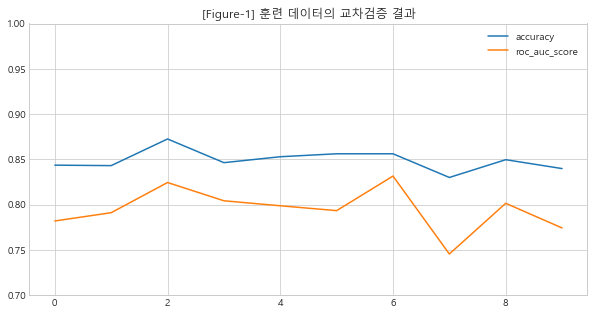

In [36]:
plt.plot( accuracy , label='accuracy')
# plt.plot( precision , label='precision')
# plt.plot( recall_score , label='recall_score')
# plt.plot( f1_score , label='f1_score')
plt.ylim(0.7, 1.0)
plt.plot( roc_auc_score , label='roc_auc_score')
plt.legend()
plt.title( '[Figure-1] 훈련 데이터의 교차검증 결과')
plt.show()

#### [2]  테스트 데이터 검증

In [37]:
# 테스트용 데이터를 통해 예측하기
y_pred = best_model.predict(X_test)

# 테스트 데이터 정확도
result = accuracy_score( y_test, y_pred ) 
result # 정확도

0.8521341463414634

### (6) 모델 저장

In [38]:
with open('model/sentiment_analysis_Model1.dat','wb') as fp:
    pickle.dump(best_model, fp)
print('저장완료')

저장완료


### (7) 모델 불러오기

In [39]:
with open('model/sentiment_analysis_Model1.dat', 'rb') as fp:
    new_model = pickle.load(fp)
print('출력 완료')

출력 완료


### (8) 추정 확률 알아보기

In [40]:
# 클래스 순서에 따른 추정 확률 [ 0일 확률, 1일 확률 ]
proba = new_model.predict_proba( X_test )
proba

array([[0.85480701, 0.14519299],
       [0.85167749, 0.14832251],
       [0.76971372, 0.23028628],
       ...,
       [0.99071408, 0.00928592],
       [0.98713292, 0.01286708],
       [0.19970872, 0.80029128]])

In [41]:
# 각 값에 대한 추정 확률과 실제 값을 데이터 프레임으로 형성
proba_df = pd.DataFrame(proba)
proba_df['target'] = new_model.predict(X_test)
proba_df

,0,1,target
0,0.854807,0.145193,0.0
1,0.851677,0.148323,0.0
2,0.769714,0.230286,0.0
3,0.754732,0.245268,0.0
4,0.935207,0.064793,0.0
...,...,...,...
1307,0.024739,0.975261,1.0
1308,0.864579,0.135421,0.0
1309,0.990714,0.009286,0.0
1310,0.987133,0.012867,0.0


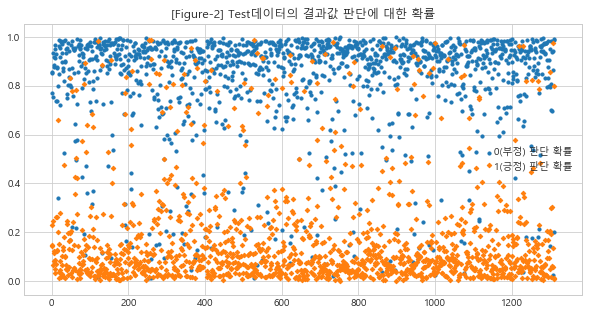

In [42]:
plt.scatter( range(len(proba_df[0])), proba_df[0] , label='0(부정) 판단 확률',s=10)
plt.scatter( range(len(proba_df[1])), proba_df[1] , label='1(긍정) 판단 확률',marker='D', s=10)
plt.legend()
plt.title( '[Figure-2] Test데이터의 결과값 판단에 대한 확률')
plt.show()

### ※ CounterVectorizer는 생성한 후 fit 시키지 않고 transform
- **NOT** fit_transform 

### ※ Tf-Idf는 학습할 때 사용한 Tf-Idf를 사용해야 한다.

In [43]:
# **저장한 tf-idf 벡터라이저 사용**
with open('model/tfidf_vectorizer_0511.dat', 'rb') as fp:
    new_tfidf_vectorizer = pickle.load(fp)
print('출력 완료')

출력 완료


In [48]:
# 2. 임의의 텍스트로 예측
test = [
    '박영선 아웃',
    '오세훈은 뭐냐? 무상급식 기억 안 나냐?',
    '더불어 만진당에서 나온 후보라..',
    '국민의 짐',
    '성추행당은 꺼져라',
    '오세훈 후보 지지합니다',
    '참나',
    '노답',
    '누굴 뽑으라는거야',
    '둘다 별로야'
]

# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(test)

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

y_pred = new_model.predict(X)
y_pred

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

## 5. 후보자의 이름이나, 정당의 이름이 들어갈 경우 

In [49]:
test2 = [
    '박영선',
    '오세훈',
    '김영춘',
    '박형준',
    '더불어 민주당',
    '국민의 힘',
]

# CounterVectorizer & Tf-Idf
X = index_vectorizer.transform(test2)
X = new_tfidf_vectorizer.transform(X)

# 긍정/부정 예측 결과
new_model.predict(X)

array([0., 1., 0., 0., 0., 0.])

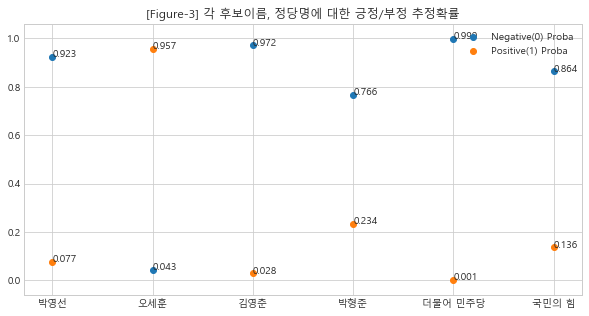

In [50]:
# 추정 확률 알아보기
proba_0 = new_model.predict_proba(X)[:,0]
proba_1 = new_model.predict_proba(X)[:,1]

plt.scatter( test2, proba_0 , label='Negative(0) Proba')
plt.scatter( test2, proba_1 , label='Positive(1) Proba')

for idx, val in zip(test2, proba_0):
    plt.text(idx, val, f'{round(val,3)}' )    
for idx, val in zip(test2, proba_1):
    plt.text(idx, val, f'{round(val,3)}' )    
plt.title('[Figure-3] 각 후보이름, 정당명에 대한 긍정/부정 추정확률')
plt.legend()
plt.show()

- 위 모델은 **여당**과 **여당의 후보**가 글에 포함될 경우 **부정**으로 판단함을 알 수 있음
    - 보수 언론의 데이터가 많아서 이러한 도출 되었거나
    - 실제 여론을 반영한 결과라고 해석할 수 있다.
- 기존 모델과 차이점은 박형준 후보 역시 부정적으로 평가한다는 것

## 6. 후보자별 긍정률 예측

In [51]:
# 감성분석 모델 불러오기
with open('model/전처리 데이터 사용한 모델/sentiment_analysis_Model1.dat', 'rb') as fp:
    new_model = pickle.load(fp)
print('출력 완료')

출력 완료


In [52]:
# Tf-Idf Vectorizer 불러오기
with open('model/전처리 데이터 사용한 모델/tfidf_vectorizer_0511.dat', 'rb') as fp:
    new_tfidf_vectorizer = pickle.load(fp)
print('출력 완료')

출력 완료


### 모델2로 예측한 후보자 데이터

In [53]:
df_byModel2 = pd.read_csv('./data/prediction_byModel2/data_byModel2_0512_0054.csv', index_col=0)
df_byModel2

,area,candidate,candidate_eval,party,party_eval,title_comment,area_candidate
0,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마...,오세훈
1,1.0,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 박영선은 정동영이 얻은 프로 선에...,박영선
2,1.0,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 빵 산 이가 서울시장 되면 서울은 ...,박영선
3,1.0,1.0,0.0,1.0,0.0,재보궐 부산 김영춘 박형준 서울도 양자 대결 서울시장 후보 더 든 대치어 없음 ...,박영선
4,2.0,NaN,NaN,1.0,0.0,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은 오거돈 선거이고 오거돈 치부...,박영선
...,...,...,...,...,...,...,...
144134,NaN,NaN,NaN,NaN,NaN,논설위원의 단도직입한 일해져 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해야...,오세훈
144135,NaN,NaN,NaN,NaN,NaN,논설위원의 단도직입한 일해져 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해야...,오세훈
144136,NaN,NaN,NaN,NaN,NaN,논설위원의 단도 직입한 일해저 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해...,오세훈
144137,NaN,NaN,NaN,NaN,NaN,논설위원의 단도 직입한 일해저 터널 경제성 없지만 동북아 경제권 차원서 장기 검토해...,오세훈


In [58]:
df['pre_title_comment'].isnull().sum()

7

In [60]:
total_X = df_byModel2['title_comment']
total_X = total_X.dropna()

In [61]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

y_pred = new_model.predict(X)
y_pred

array([0., 0., 0., ..., 0., 0., 1.])

In [62]:
y_pred

array([0., 0., 0., ..., 0., 0., 1.])

### 후보별 예측 긍정/부정률 확인하기

In [64]:
pre_idx = df_byModel2[ df_byModel2['title_comment'].notnull() ].index
target_df = df_byModel2[['title_comment','area_candidate']].iloc[pre_idx]
target_df['pred_sentiment'] = y_pred

In [65]:
a = target_df.groupby('area_candidate').mean().loc[['박영선','오세훈','김영춘','박형준']]
a['pred_sentiment']

area_candidate
박영선    0.042487
오세훈    0.031592
김영춘    0.040816
박형준    0.046575
Name: pred_sentiment, dtype: float64

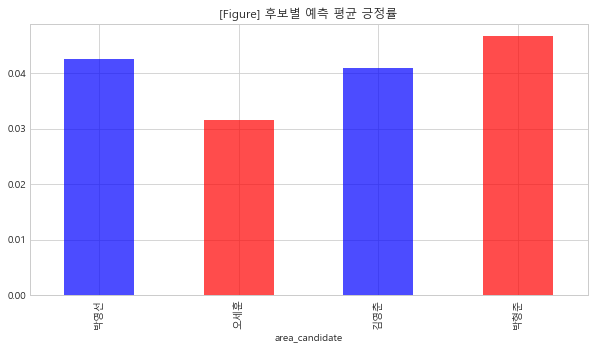

In [66]:
a['pred_sentiment'].plot(kind='bar', color=['b','r','b','r'], alpha=0.7)
plt.title('[Figure] 후보별 예측 평균 긍정률')
plt.show()

## 7. 부정단어 추출
- 6번 결과가 이상해서 안 함

In [ ]:
# (단어인덱스, 회귀 계수) 형태로 만들기
tmp = list(enumerate(new_model.coef_[0]))
# display(tmp)

In [ ]:
# (회귀계수, 인덱스) 형태인 튜플 생성
tmp2 = ( (value, index) for index, value in tmp)
tmp2

In [ ]:
# 오름차순 정렬: 회귀계수가 가장 높은 것부터 출력
coef_pos_index = sorted(tmp2, reverse=True) 
# coef_pos_index # 결과적으로 중요도 나타냄

## 긍정/부정 단어 확인
- 단어 사전 변형하기
    - { 단어: 단어 인덱스}에서 { 단어 인덱스: 단어 } 형태로 변형
- 긍정 단어 20개, 부정 단어 20개 파악

In [ ]:
index_vectorizer.vocabulary_ # {단어: 인덱스, ...} 딕셔너리
index_vectorizer.vocabulary_.items() #  [ (단어: 인덱스), ..] 형태

# 단어 사전
word_dict={}

for pos, index in index_vectorizer.vocabulary_.items():
    # print(pos)
    word_dict[index] = pos
    
word_dict

In [ ]:
coef_pos_text = []

for value, index in coef_pos_index:
    # 각 인덱스에 해당하는 실제 단어 확인
    # print(word_dict[index])
    # print(value) # 회귀계수
    coef_pos_text.append( ( value, word_dict[index]) )
    
coef_pos_text

In [ ]:
# 회귀 계수가 높은 순으로 형용사들을 리스트에 담는다.
adj_list_by_coef = []
for i in coef_pos_text:
    if i[1].split('/')[1] == 'Adjective':
        adj_list_by_coef.append((float(i[0]),i[1].split('/')[0]))

In [ ]:
# 긍정 판단에 영향을 주는 형용사 top 50
np.array(adj_list_by_coef[:50])[:,1]

plt.bar( np.array(adj_list_by_coef[:50])[:,1],
         np.array(adj_list_by_coef[:50])[:,0].astype(float))
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 부정 판단에 영향을 주는 형용사 top 50
np.array(adj_list_by_coef[-50:])[:,1]

plt.bar( np.array(adj_list_by_coef[-50:])[:,1],
         np.array(adj_list_by_coef[-50:])[:,0].astype(float))
plt.xticks(rotation=90)
plt.show()

In [ ]:
adj_list_by_coef

import pickle

# 리스트를 저장
with open('data/0409/adj_list_by_model1_0409.pickle', 'wb') as f:
    pickle.dump(adj_list_by_coef, f, pickle.HIGHEST_PROTOCOL)